CIFAR-10 dataset

Task #1

In [1]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [2]:
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
import torch

torch.manual_seed(42)

dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

targets = np.array(dataset.targets)

indices = np.arange(len(dataset))

subset_indices, _ = train_test_split(
    indices,
    train_size=15000,
    stratify=targets,
    random_state=42
)

dataset = torch.utils.data.Subset(dataset, subset_indices)

In [5]:
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([32, 3, 96, 96])


Task #2

In [6]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)

Total parameters: 11689512
Trainable parameters: 11689512


In [8]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

Task #3

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)

In [11]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

Trainable parameters: 5130


Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [13]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 8

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluation
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch [{epoch+1}/8]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")
    print("-" * 30)

Epoch [1/8]
Train Loss: 0.9599, Train Acc: 0.6804
Test  Loss: 0.7624, Test  Acc: 0.7441
------------------------------
Epoch [2/8]
Train Loss: 0.8027, Train Acc: 0.7282
Test  Loss: 0.7310, Test  Acc: 0.7512
------------------------------
Epoch [3/8]
Train Loss: 0.7748, Train Acc: 0.7380
Test  Loss: 0.7290, Test  Acc: 0.7565
------------------------------
Epoch [4/8]
Train Loss: 0.7628, Train Acc: 0.7403
Test  Loss: 0.7386, Test  Acc: 0.7490
------------------------------
Epoch [5/8]
Train Loss: 0.7579, Train Acc: 0.7423
Test  Loss: 0.7171, Test  Acc: 0.7603
------------------------------
Epoch [6/8]
Train Loss: 0.7594, Train Acc: 0.7431
Test  Loss: 0.7094, Test  Acc: 0.7628
------------------------------
Epoch [7/8]
Train Loss: 0.7540, Train Acc: 0.7487
Test  Loss: 0.7249, Test  Acc: 0.7565
------------------------------
Epoch [8/8]
Train Loss: 0.7441, Train Acc: 0.7449
Test  Loss: 0.7198, Test  Acc: 0.7602
------------------------------


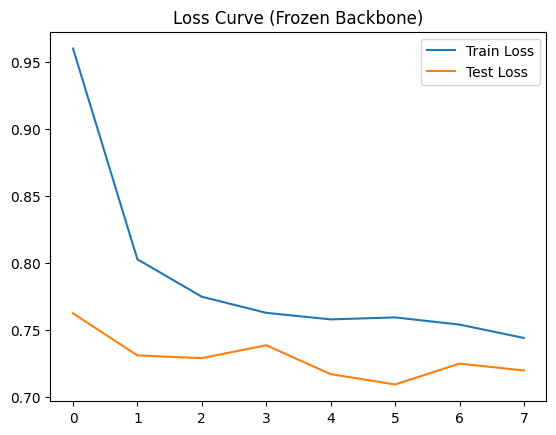

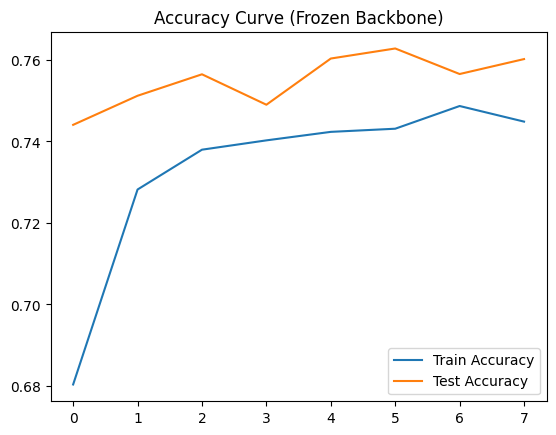

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curve (Frozen Backbone)")
plt.show()

plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curve (Frozen Backbone)")
plt.show()

In [15]:
import copy

frozen_model = copy.deepcopy(model)

Task #4

In [16]:
# сначала заморозим всё
for param in model.parameters():
    param.requires_grad = False

# размораживаем последний conv блок
for param in model.layer4.parameters():
    param.requires_grad = True

# и classification head
for param in model.fc.parameters():
    param.requires_grad = True

In [17]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)

In [18]:
num_epochs = 5

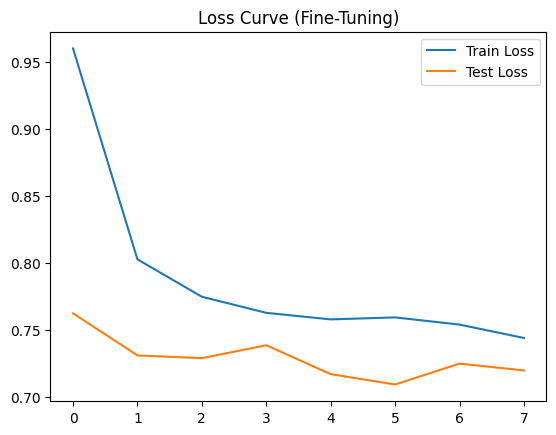

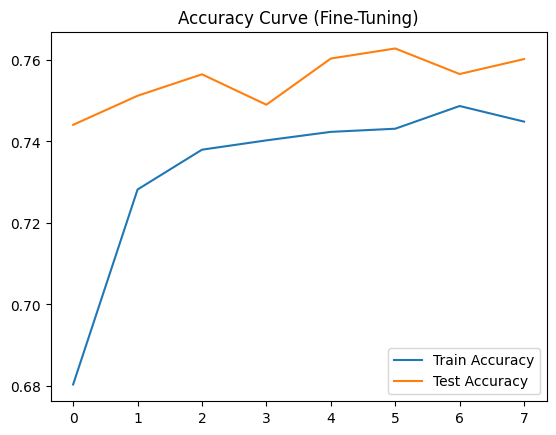

In [19]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curve (Fine-Tuning)")
plt.show()

plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curve (Fine-Tuning)")
plt.show()

In [20]:
fine_tuned_model = model

Task #5

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return acc, precision, recall, f1

In [22]:
acc_frozen, prec_frozen, rec_frozen, f1_frozen = evaluate_model(
    frozen_model, test_loader, device
)

In [23]:
acc_ft, prec_ft, rec_ft, f1_ft = evaluate_model(
    fine_tuned_model, test_loader, device
)

In [24]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Frozen Backbone", "Fine-Tuned"],
    "Accuracy": [acc_frozen, acc_ft],
    "Precision (Macro)": [prec_frozen, prec_ft],
    "Recall (Macro)": [rec_frozen, rec_ft],
    "F1 Score (Macro)": [f1_frozen, f1_ft]
})

print(results)

             Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0  Frozen Backbone    0.7602           0.761046        0.759544   
1       Fine-Tuned    0.7602           0.761046        0.759544   

   F1 Score (Macro)  
0          0.758438  
1          0.758438  


Task #6

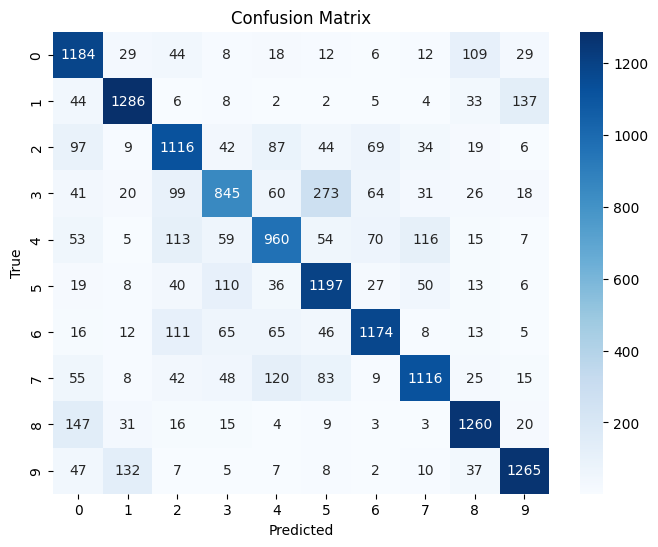

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [26]:
classes = test_loader.dataset.dataset.classes  # CIFAR-10 class names

correct_imgs = []
wrong_imgs = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_imgs) < 3:
                correct_imgs.append((images[i].cpu(), labels[i], preds[i]))
            elif preds[i] != labels[i] and len(wrong_imgs) < 3:
                wrong_imgs.append((images[i].cpu(), labels[i], preds[i]))
        
        if len(correct_imgs) == 3 and len(wrong_imgs) == 3:
            break

In [27]:
def imshow(img):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

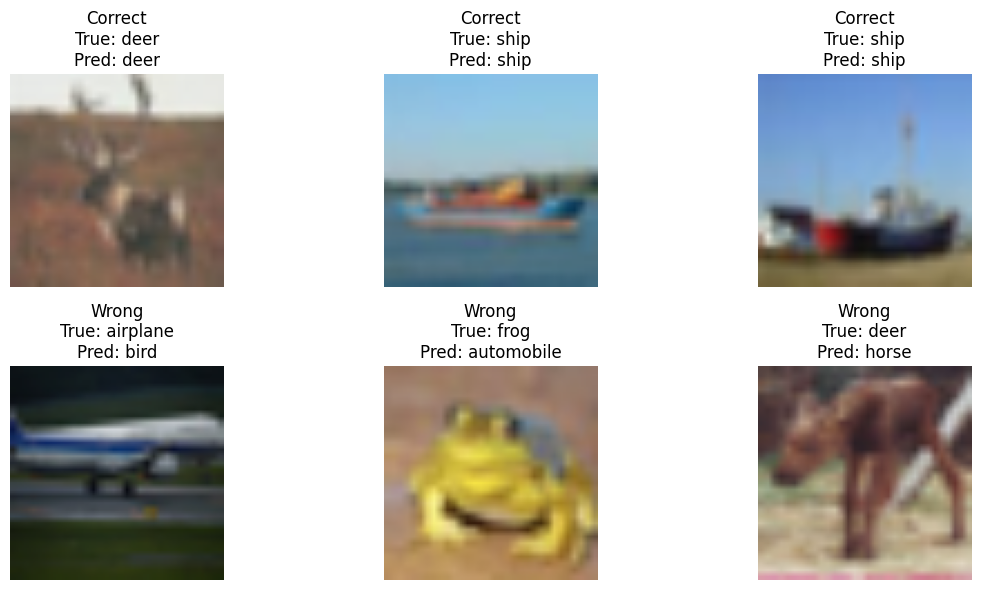

In [28]:
plt.figure(figsize=(12,6))

# Correct
for i, (img, true, pred) in enumerate(correct_imgs):
    plt.subplot(2,3,i+1)
    imshow(img)
    plt.title(f"Correct\nTrue: {classes[true]}\nPred: {classes[pred]}")

# Wrong
for i, (img, true, pred) in enumerate(wrong_imgs):
    plt.subplot(2,3,i+4)
    imshow(img)
    plt.title(f"Wrong\nTrue: {classes[true]}\nPred: {classes[pred]}")

plt.tight_layout()
plt.show()

Task #7

In [29]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [30]:
scratch_model = SmallCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(scratch_model.parameters(), lr=0.001)

In [31]:
total_params = sum(p.numel() for p in scratch_model.parameters())
print("Total parameters (SmallCNN):", total_params)

Total parameters (SmallCNN): 4814666


In [32]:
num_epochs = 8

train_losses_s = []
test_losses_s = []
train_accs_s = []
test_accs_s = []

scratch_model = scratch_model.to(device)

for epoch in range(num_epochs):
    #TRAIN
    scratch_model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = scratch_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    train_losses_s.append(train_loss)
    train_accs_s.append(train_acc)
    
    #TEST
    scratch_model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = scratch_model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    
    test_losses_s.append(test_loss)
    test_accs_s.append(test_acc)
    
    print(f"Epoch [{epoch+1}/8]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")
    print("-" * 30)

Epoch [1/8]
Train Loss: 1.3604, Train Acc: 0.5079
Test  Loss: 1.0928, Test  Acc: 0.6083
------------------------------
Epoch [2/8]
Train Loss: 0.9175, Train Acc: 0.6756
Test  Loss: 0.8912, Test  Acc: 0.6855
------------------------------
Epoch [3/8]
Train Loss: 0.6807, Train Acc: 0.7591
Test  Loss: 0.8738, Test  Acc: 0.6971
------------------------------
Epoch [4/8]
Train Loss: 0.4567, Train Acc: 0.8394
Test  Loss: 0.9449, Test  Acc: 0.6961
------------------------------
Epoch [5/8]
Train Loss: 0.2685, Train Acc: 0.9048
Test  Loss: 1.1708, Test  Acc: 0.6999
------------------------------
Epoch [6/8]
Train Loss: 0.1576, Train Acc: 0.9457
Test  Loss: 1.4298, Test  Acc: 0.6925
------------------------------
Epoch [7/8]
Train Loss: 0.1205, Train Acc: 0.9573
Test  Loss: 1.7424, Test  Acc: 0.6725
------------------------------
Epoch [8/8]
Train Loss: 0.1024, Train Acc: 0.9651
Test  Loss: 1.8465, Test  Acc: 0.6793
------------------------------


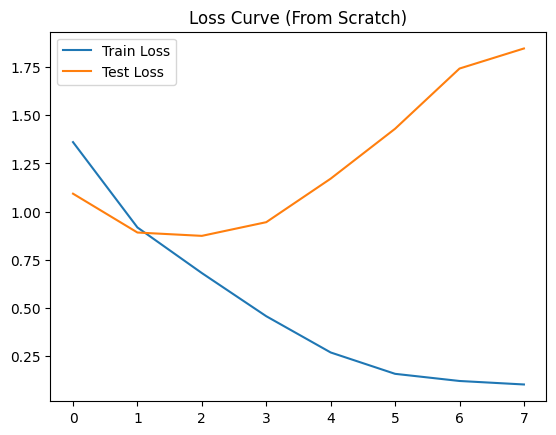

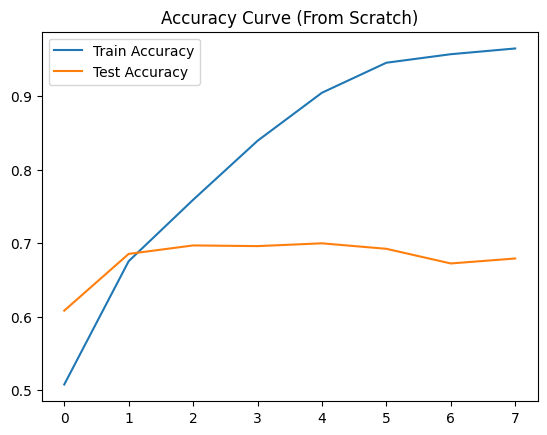

In [33]:
import matplotlib.pyplot as plt

# Loss
plt.plot(train_losses_s, label="Train Loss")
plt.plot(test_losses_s, label="Test Loss")
plt.legend()
plt.title("Loss Curve (From Scratch)")
plt.show()

# Accuracy
plt.plot(train_accs_s, label="Train Accuracy")
plt.plot(test_accs_s, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curve (From Scratch)")
plt.show()

In [34]:
acc_s, prec_s, rec_s, f1_s = evaluate_model(
    scratch_model, test_loader, device
)

print("Accuracy:", acc_s)
print("Macro F1:", f1_s)

Accuracy: 0.6792666666666667
Macro F1: 0.682342341153951


In [35]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["Frozen", "Fine-Tuned", "From Scratch"],
    "Accuracy": [acc_frozen, acc_ft, acc_s],
    "Macro F1": [f1_frozen, f1_ft, f1_s]
})

print(comparison)

          Model  Accuracy  Macro F1
0        Frozen  0.760200  0.758438
1    Fine-Tuned  0.760200  0.758438
2  From Scratch  0.679267  0.682342


Task #8

In [36]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

image = images[0].unsqueeze(0).to(device)
label = labels[0]

In [37]:
feature_maps = {}

def get_features(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

# регистрируем хуки
model.conv1.register_forward_hook(get_features("early"))
model.layer4.register_forward_hook(get_features("deep"))

# forward pass
model.eval()
with torch.no_grad():
    _ = model(image)

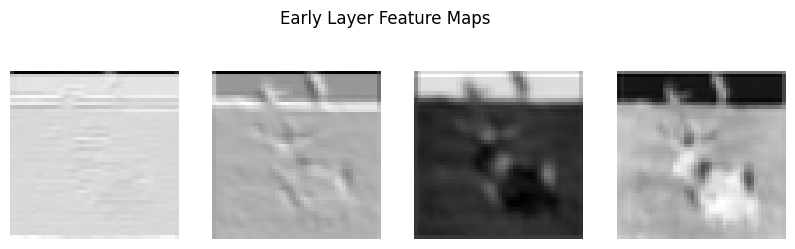

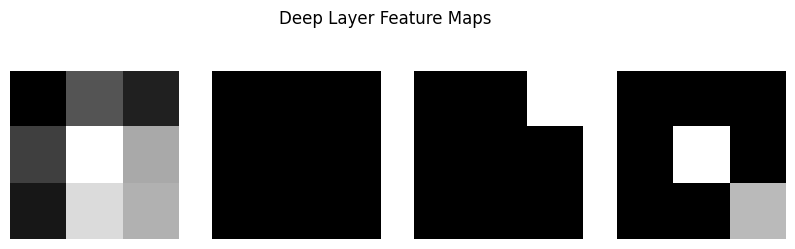

In [38]:
import matplotlib.pyplot as plt

def visualize_feature_maps(feature_tensor, title):
    feature_tensor = feature_tensor.squeeze(0).cpu()
    
    plt.figure(figsize=(10,3))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(feature_tensor[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_feature_maps(feature_maps["early"], "Early Layer Feature Maps")
visualize_feature_maps(feature_maps["deep"], "Deep Layer Feature Maps")

Task #9

In [39]:
params_pretrained = sum(p.numel() for p in fine_tuned_model.parameters() if p.requires_grad)
print("Trainable params (Pretrained):", params_pretrained)

Trainable params (Pretrained): 8398858


In [40]:
params_scratch = sum(p.numel() for p in scratch_model.parameters() if p.requires_grad)
print("Trainable params (Scratch):", params_scratch)

Trainable params (Scratch): 4814666


In [41]:
import time

start = time.time()

# одна эпоха обучения
scratch_model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = scratch_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

end = time.time()

epoch_time = end - start
print("Time per epoch:", epoch_time)

Time per epoch: 213.6609606742859


In [43]:
import time

start = time.time()

fine_tuned_model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = fine_tuned_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

end = time.time()

time_pretrained = end - start
print("Time per epoch (Pretrained):", time_pretrained)

Time per epoch (Pretrained): 192.47854661941528


In [44]:
start = time.time()

scratch_model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = scratch_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

end = time.time()

time_scratch = end - start
print("Time per epoch (Scratch):", time_scratch)

Time per epoch (Scratch): 211.64524865150452


In [45]:
import pandas as pd

efficiency_table = pd.DataFrame({
    "Model": ["Pretrained (Fine-Tuned)", "From Scratch"],
    "Trainable Parameters": [params_pretrained, params_scratch],
    "Time per Epoch (sec)": [time_pretrained, time_scratch],
    "Final Test Accuracy": [acc_ft, acc_s]
})

print(efficiency_table)

                     Model  Trainable Parameters  Time per Epoch (sec)  \
0  Pretrained (Fine-Tuned)               8398858            192.478547   
1             From Scratch               4814666            211.645249   

   Final Test Accuracy  
0             0.760200  
1             0.679267  
